In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn 
import torch 
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2]:

from matplotlib import rc 
from matplotlib.animation import FuncAnimation as animate 
rc('animation',html='html5')

In [3]:
# dataset source: https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5

N = 400
theta = np.sqrt(np.random.rand(N))*2*np.pi # np.linspace(0,2*np.pi,100)

r_a = 2*theta + np.pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - np.pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

np.savetxt("result.csv", res, delimiter=",", header="x,y,label", comments="", fmt='%.5f')


In [4]:
df = pd.read_csv('result.csv')
df.head(3),df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       800 non-null    float64
 1   y       800 non-null    float64
 2   label   800 non-null    float64
dtypes: float64(3)
memory usage: 18.9 KB


(          x         y  label
 0  14.97897  -3.99543    0.0
 1   9.94491   3.16164    1.0
 2   9.83488 -10.42646    0.0,
 None)

In [5]:
class Set(Dataset): 
    def __init__(self,dataset,length=1000) -> None:
        dataset.x = (dataset.x - dataset.x.mean())/(dataset.x.max()-dataset.x.min())
        dataset.y = (dataset.y - dataset.y.mean())/(dataset.y.max()-dataset.y.min())
        self.x = dataset[['x','y']][:length].to_numpy() 
        self.y = dataset['label'][:length].to_numpy()
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        
    @property
    def shape(self):
        return f"x: ({self.x.shape}) y: ({self.y.shape})"

    @property
    def plot(self):
        plt.scatter(self.x[:,0],self.x[:,1], c=self.y,cmap=plt.cm.coolwarm)
    
    def __getitem__(self,i):
        return self.x[i],self.y[i] 

    def __len__(self):
        return len(self.x)

In [6]:
class MLP(nn.Module):
    def __init__(self,inFeatures=2,hiddenNodes=1000,numClass=2) -> None:
        super(MLP,self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(inFeatures,hiddenNodes),
            nn.ReLU(),
            nn.Linear(hiddenNodes,hiddenNodes),
            nn.ReLU(),
            nn.Linear(hiddenNodes,numClass)
        )
    def forward(self,x):
        return self.layer(x)


In [7]:
model = MLP()
LossFunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)


In [8]:
data = Set(df)
trainloader = DataLoader(data,batch_size=20)

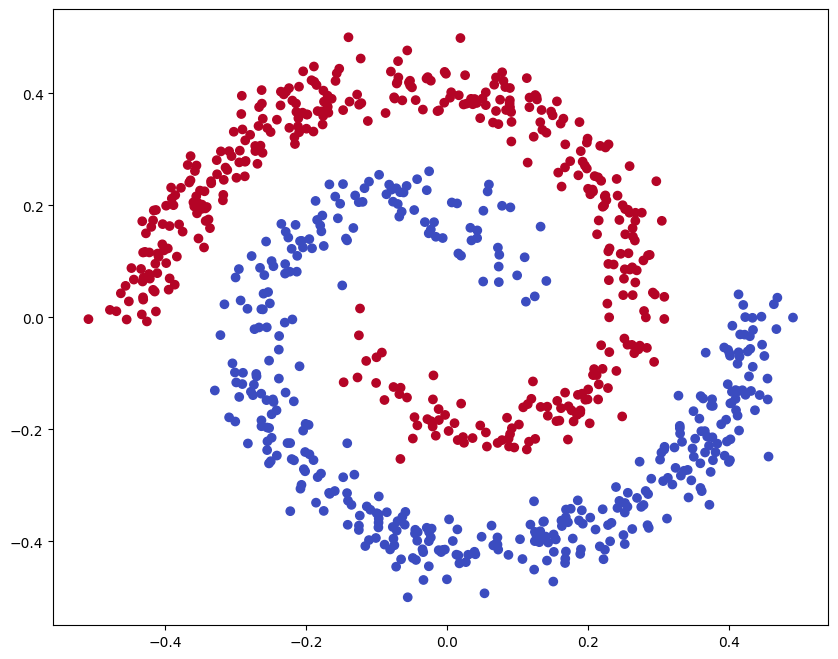

In [9]:
data.plot

KeyboardInterrupt: 

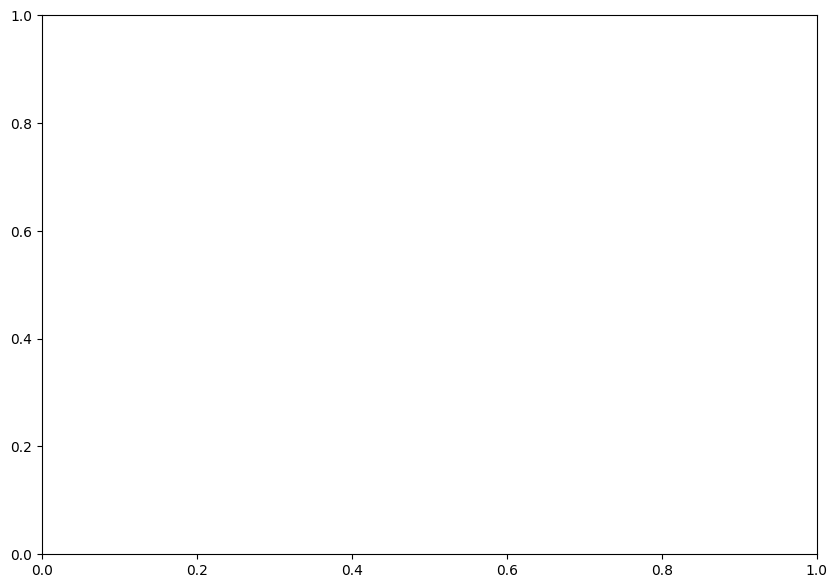

In [10]:
h = 0.02
x_min, x_max = data.x[:, 0].numpy().min() - 1, data.x[:, 0].numpy().max() + 1
y_min, y_max = data.x[:, 1].numpy().min() - 1, data.x[:, 1].numpy().max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
inp = torch.Tensor(np.c_[xx.ravel(),yy.ravel()])


fig , ax = plt.subplots(figsize = (10,7))

LAMBDA = 0.1

def train(_): 
    
    loss_ = 0
    for x,y in trainloader:
        optimizer.zero_grad()
        # print(x.shape)
        l2 = sum(p.pow(2).sum() for p in model.parameters())
        yhat = model(x)
        loss = LossFunc(yhat,y) + LAMBDA*l2
        loss.backward()
        optimizer.step()
        loss_+=loss.item()


for i in tqdm(range(2000)):train(i)




__,yhatt = torch.max(model(inp),1)    
yhatt = yhatt.numpy().reshape(xx.shape)
ax.clear()
ax.contourf(xx, yy, yhatt, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(data.x[:, 0], data.x[:, 1], c=data.y, s=40, cmap=plt.cm.coolwarm)
plt.xlim([-1,1])
plt.ylim([-1,1])

# plots = animate(fig,train,frames=2000,interval = 60,repeat=False)
# plots
